In [64]:
import os
# Run in terminal or command prompt
# python3 -m spacy download en
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
news_categories = ["business","entertainment","politics","sport","tech"]




train_docs_list = []
train_news = []

for category in news_categories:
    for news in os.listdir("dataset/train/" + str(category)):
        f = open("dataset/train/" + str(category) + "/" + str(news),"r")
        train_news.append(f.read())
        train_docs_list.append(str(category) + "_" + str(news))
    

train_raw_df = pd.DataFrame(train_news,columns=["News"])
train_raw_df.index = train_docs_list

print("We have total of " + str(train_raw_df.shape[0]) + " Training Documents from 5 different categories.")

train_raw_df.head()

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We have total of 1888 Training Documents from 5 different categories.


,News
business_001.txt,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...
business_002.txt,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...
business_003.txt,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...
business_004.txt,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...
business_005.txt,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...


In [67]:

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
stop_words.extend(['say','may','order','lot','go','like','great','service','came','got','use' , 'work' ,'would' , 'code' ,'want' , 'try' , 'way' , 'make' ,'find' , 'know' , 'make' , 'look' ,'get' ,'change' , 'see' , 'set', 'need' , 'example' ,'also' , 'however', 'run' , 'use' , 'try', 'use' ])

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:

def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")


C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:

train_raw_df['News_Cleaned'] = train_raw_df['News'].apply(normalize_text)

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
print(train_raw_df.iloc[1]['News_Cleaned'])

Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He's taking a longer-term view, laying out a set of conditions under which the

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
nlp = spacy.load("en_core_web_sm")


C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords.words('english') and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)


train_raw_df['News_Cleaned']  = train_raw_df['News_Cleaned'] .apply(lambda x: cleanup_text(x, False))

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
print(train_raw_df.iloc[0]['News_Cleaned'])

ad sale boost time warner profitquarterly profit us media giant timewarner jump 76 1.13bn â£600 three month december 639 year early . firm one big investor google benefit sale high speed internet connection high advert sale . timewarner say fourth quarter sale rise 2 11.1bn 10.9bn . profit buoy one gain offset profit dip warner bros less user aol.time warner say friday 8 search engine google . internet business aol mix fortune . lose 464,000 subscriber fourth quarter profit low precede three quarter . however company say aol 's underlie profit exceptional item rise 8 back strong internet advertising revenue . hope increase subscriber offer online service free timewarner internet customer try sign aol 's exist customer high speed broadband . timewarner also restate 2000 2003 result follow probe us securities exchange commission sec close conclude . time warner 's fourth quarter profit slightly well analyst expectation . film division see profit slump 27 284 help box office flop alexande

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
train_raw_df.head()

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,News,News_Cleaned
business_001.txt,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...,ad sale boost time warner profitquarterly profit us media giant timewarner jump 76 1.13bn â£600 ...
business_002.txt,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...,dollar gain greenspan speechthe dollar hit high level euro almost three month federal reserve he...
business_003.txt,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...,yukos unit buyer face loan claimthe owner embattle russian oil giant yukos ask buyer former prod...
business_004.txt,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...,high fuel price hit ba 's profitsbritish airways blame high fuel price 40 drop profit . report r...
business_005.txt,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...,pernod takeover talk lift domecqshares uk drink food firm allied domecq rise speculation could t...


In [76]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(train_raw_df['News_Cleaned']))

print(data_words[:5])

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['ad', 'sale', 'boost', 'time', 'warner', 'profitquarterly', 'profit', 'us', 'media', 'giant', 'timewarner', 'jump', 'bn', 'three', 'month', 'december', 'year', 'early', 'firm', 'one', 'big', 'investor', 'google', 'benefit', 'sale', 'high', 'speed', 'internet', 'connection', 'high', 'advert', 'sale', 'timewarner', 'say', 'fourth', 'quarter', 'sale', 'rise', 'bn', 'bn', 'profit', 'buoy', 'one', 'gain', 'offset', 'profit', 'dip', 'warner', 'bros', 'less', 'user', 'aol', 'time', 'warner', 'say', 'friday', 'search', 'engine', 'google', 'internet', 'business', 'aol', 'mix', 'fortune', 'lose', 'subscriber', 'fourth', 'quarter', 'profit', 'low', 'precede', 'three', 'quarter', 'however', 'company', 'say', 'aol', 'underlie', 'profit', 'exceptional', 'item', 'rise', 'back', 'strong', 'internet', 'advertising', 'revenue', 'hope', 'increase', 'subscriber', 'offer', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'try', 'sign', 'aol', 'exist', 'customer', 'high', 'speed', 'broad

In [78]:
print(data_words[:35])

[['ad', 'sale', 'boost', 'time', 'warner', 'profitquarterly', 'profit', 'us', 'media', 'giant', 'timewarner', 'jump', 'bn', 'three', 'month', 'december', 'year', 'early', 'firm', 'one', 'big', 'investor', 'google', 'benefit', 'sale', 'high', 'speed', 'internet', 'connection', 'high', 'advert', 'sale', 'timewarner', 'say', 'fourth', 'quarter', 'sale', 'rise', 'bn', 'bn', 'profit', 'buoy', 'one', 'gain', 'offset', 'profit', 'dip', 'warner', 'bros', 'less', 'user', 'aol', 'time', 'warner', 'say', 'friday', 'search', 'engine', 'google', 'internet', 'business', 'aol', 'mix', 'fortune', 'lose', 'subscriber', 'fourth', 'quarter', 'profit', 'low', 'precede', 'three', 'quarter', 'however', 'company', 'say', 'aol', 'underlie', 'profit', 'exceptional', 'item', 'rise', 'back', 'strong', 'internet', 'advertising', 'revenue', 'hope', 'increase', 'subscriber', 'offer', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'try', 'sign', 'aol', 'exist', 'customer', 'high', 'speed', 'broad

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ad', 'sale', 'boost', 'time', 'warner', 'profitquarterly', 'profit', 'us', 'media', 'giant', 'timewarner', 'jump', 'bn', 'three', 'month', 'december', 'year', 'early', 'firm', 'one', 'big', 'investor', 'google', 'benefit', 'sale', 'high_speed', 'internet', 'connection', 'high', 'advert', 'sale', 'timewarner', 'say', 'fourth_quarter', 'sale', 'rise', 'bn', 'bn', 'profit', 'buoy', 'one', 'gain', 'offset', 'profit', 'dip', 'warner_bros', 'less', 'user', 'aol', 'time', 'warner', 'say', 'friday', 'search_engine', 'google', 'internet', 'business', 'aol', 'mix', 'fortune', 'lose', 'subscriber', 'fourth_quarter', 'profit', 'low', 'precede', 'three', 'quarter', 'however', 'company', 'say', 'aol', 'underlie', 'profit', 'exceptional', 'item', 'rise', 'back', 'strong', 'internet', 'advertising_revenue', 'hope', 'increase', 'subscriber', 'offer', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'try', 'sign', 'aol', 'exist', 'customer', 'high_speed', 'broadband', 'timewarner', '

In [80]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:

data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['ad', 'sale', 'time', 'profitquarterly', 'profit', 'medium', 'giant', 'month', 'year', 'early', 'firm', 'big', 'investor', 'benefit', 'sale', 'internet', 'connection', 'high', 'advert', 'sale', 'sale', 'rise', 'profit', 'gain', 'profit', 'dip', 'less', 'user', 'business', 'fortune', 'lose', 'subscriber', 'profit', 'low', 'quarter', 'company', 'profit', 'exceptional', 'item', 'rise', 'back', 'strong', 'internet', 'hope', 'increase', 'subscriber', 'offer', 'online', 'free', 'customer', 'sign', 'exist', 'customer', 'broadband', 'timewarner', 'result', 'follow', 'probe', 'close', 'time', 'profit', 'slightly', 'well', 'analyst', 'profit', 'slump', 'help', 'contrast', 'year', 'early', 'third', 'final', 'film', 'trilogy', 'boost', 'result', 'full', 'year', 'performance', 'revenue', 'grow', 'financial', 'performance', 'strong', 'exceed', 'full', 'year', 'objective', 'greatly', 'enhance', 'flexibility', 'parson', 'operate', 'earn', 'growth', 'around', 'expect', 'high', 'revenue', 'wide', 'pro

In [82]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 8), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 2), (85, 1), (86, 2), (87, 5), (88, 1), (89, 1), (90, 1), (91, 2), (92, 2), (93, 2), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 4)]]


In [83]:

id2word[0]

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'account'

In [84]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('account', 2),
  ('ad', 1),
  ('adjust', 1),
  ('advert', 1),
  ('already', 1),
  ('amount', 1),
  ('analyst', 1),
  ('around', 1),
  ('back', 1),
  ('benefit', 1),
  ('big', 1),
  ('book', 1),
  ('boost', 1),
  ('broadband', 1),
  ('business', 1),
  ('charge', 1),
  ('close', 1),
  ('company', 2),
  ('connection', 1),
  ('contrast', 1),
  ('customer', 2),
  ('deal', 2),
  ('dip', 1),
  ('early', 2),
  ('earn', 1),
  ('effort', 1),
  ('enhance', 1),
  ('estimate', 1),
  ('exceed', 1),
  ('exceptional', 1),
  ('exist', 1),
  ('expect', 1),
  ('film', 1),
  ('final', 1),
  ('financial', 1),
  ('firm', 1),
  ('flexibility', 1),
  ('follow', 1),
  ('fortune', 1),
  ('free', 1),
  ('full', 2),
  ('gain', 1),
  ('german', 1),
  ('giant', 1),
  ('greatly', 1),
  ('grow', 1),
  ('growth', 1),
  ('help', 1),
  ('high', 2),
  ('hope', 1),
  ('increase', 1),
  ('inquiry', 1),
  ('intend', 1),
  ('internet', 2),
  ('investor', 1),
  ('item', 1),
  ('legal', 1),
  ('less', 1),
  ('lose', 1),
  (

In [92]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=200, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(186, '0.000*"scurrilous" + 0.000*"purposely" + 0.000*"vague" + 0.000*"unfounded" + 0.000*"tyranny" + 0.000*"forthcome" + 0.000*"sixfold" + 0.000*"untreated" + 0.000*"fraudulently" + 0.000*"pledgelabour"'), (67, '0.000*"scurrilous" + 0.000*"purposely" + 0.000*"vague" + 0.000*"unfounded" + 0.000*"tyranny" + 0.000*"forthcome" + 0.000*"sixfold" + 0.000*"untreated" + 0.000*"fraudulently" + 0.000*"pledgelabour"'), (65, '0.000*"scurrilous" + 0.000*"purposely" + 0.000*"vague" + 0.000*"unfounded" + 0.000*"tyranny" + 0.000*"forthcome" + 0.000*"sixfold" + 0.000*"untreated" + 0.000*"fraudulently" + 0.000*"pledgelabour"'), (182, '0.000*"scurrilous" + 0.000*"purposely" + 0.000*"vague" + 0.000*"unfounded" + 0.000*"tyranny" + 0.000*"forthcome" + 0.000*"sixfold" + 0.000*"untreated" + 0.000*"fraudulently" + 0.000*"pledgelabour"'), (184, '0.000*"scurrilous" + 0.000*"purposely" + 0.000*"vague" + 0.000*"unfounded" + 0.000*"tyranny" + 0.000*"forthcome" + 0.000*"sixfold" + 0.000*"untreated" + 0.000*"fraudu

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,128.0,0.0910,"turn, full, performance, wide, boost, giant, earn, gain, catch, marketing","[ad, sale, time, profitquarterly, profit, medium, giant, month, year, early, firm, big, investor..."
1,1,57.0,0.2076,"early, point, remain, close, break, level, fall, concern, recent, major","[dollar, hit, high, level, euro, almost, month, federal_reserve, head, trade, deficit, highlight..."
2,2,99.0,0.1901,"pay, money, instead, attempt, cash, avoid, intend, bank, protection, prevent","[unit, owner, russian, oil, former, production, unit, pay, back, loan, state, rosneft, buy, unit..."
3,3,74.0,0.2227,"high, increase, cost, cut, low, rise, predict, average, annual, revenue","[high, fuel, price, hit, blame, high, fuel, price, drop, profit, report, result, month, airline,..."
4,4,54.0,0.0830,"bid, storage, owner, lift, specific, fair, argument, premium, acquisition, takeover","[talk, lift, domecqshare, drink, food, firm, ally, rise, speculation, could, target, suggest, fr..."
5,5,17.0,0.0852,"similar, common, technical, feed, successive, strengthen, climb, definition, implication, consum...","[narrowly, escape, recessionjapan, economy, teeter, brink, technical, recession, month, figure, ..."
6,6,181.0,0.1371,"could, time, new, come, first, add, give, back, win, much","[job, growth, still, slow, create, job, expect, fall, jobseeker, push, low, level, year, accord,..."
7,7,63.0,0.1144,"policy, meet, meeting, fix, attend, exchange, invite, negative, object, flexible","[trade, rulesindia, attend, meet, lead, unlikely, cow, newcomer, ahead, meet, restrictive, trade..."
8,8,159.0,0.2037,"many, user, part, mean, information, let, small, child, base, broadband","[production, crop, high, average, past, year, report, crop, production, total, joint, report, fo..."
9,9,68.0,0.1566,"law, rule, appeal, foreign, kind, throw, conference, anti, danger, illegally","[court, reject, government, claim, accuse, country, big, tobacco, company, cover, effect, smoke,..."


In [95]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.1362,"labour, economy, economic, publish, forecast, entire, economist, weak, unemployment, optimistic","[cut, german, growth, estimatethe, fund, cut, growth, forecast, german, economy, report, reduce,..."
1,5.0,0.1210,"market, sell, buy, analyst, large, investment, operation, loss, prefer, investor","[deadline, midnight, settle, potential, takeover, deadline, right, division, agree, european, op..."
2,7.0,0.1411,"list, race, together, evidence, commercial, paper, transfer, exploit, alliance, employer","[could, list, stock_market, part, report, fiat, restructure, business, reach, ownership, step, c..."
3,13.0,0.1185,"home, industry, producer, ambition, domestic, climate, overseas, strict, advertise, wine","[french, wine, top, french, government, hand, struggle, wine, industry, aid, help, battle, fall,..."
4,15.0,0.0983,"take, place, lead, ahead, secure, meanwhile, newspaper, confident, confirm, purposely","[focker, keep, leadfilm, comedy, meet_focker, sequel, meet, parent, top, third, week, movie, sti..."
5,17.0,0.0852,"similar, common, technical, feed, successive, strengthen, climb, definition, implication, consum...","[narrowly, escape, recessionjapan, economy, teeter, brink, technical, recession, month, figure, ..."
6,19.0,0.1650,"become, likely, step, choice, ago, sort, achieve, probably, memory, accept","[close, debt, restructuring, offer, later, government, hopeful, creditor, accept, deal, original..."
7,21.0,0.1563,"name, type, establish, draft, alternative, drink, therefore, super, occur, nature","[turn, brewer, increasingly, money, beer, flavour, drink, rather, beer, heavily, drive, search, ..."
8,26.0,0.1564,"growth, rate, rise, grow, equipment, expand, quarter, solid, interest_rate, spending","[economy, show, solid, growththe, economy, grow, expect, expand, annual, rate, last, quarter, gr..."
9,27.0,0.1274,"hold, fast, due, datum, club, clear, sure, ground, signal, criticism","[economy, strong, forecast, economy, probably, grow, fast, rate, third, quarter, business, surve..."


C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


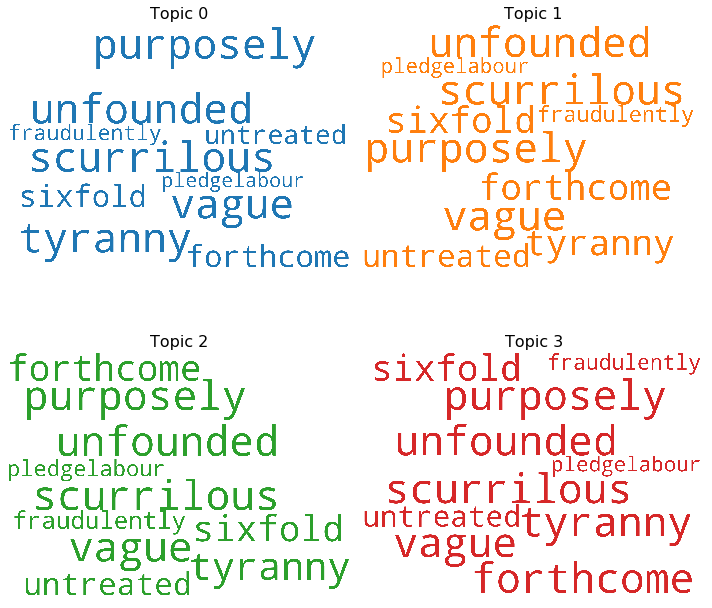

In [96]:
import wordcloud
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [97]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
df_top3words.head()

C:\Users\sanat\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_id,words
0,41,"scurrilous, \npurposely, \nvague"
1,57,"early, \npoint, \nremain"
2,61,"scurrilous, \npurposely, \nvague"
3,86,"scurrilous, \npurposely, \nvague"
4,97,"scurrilous, \npurposely, \nvague"
